**Course:** Neural Computing and Deep Learning
---
**Title:** Project 5
---
**Mahdi Mirfendereski - 401131065**
---


# Libraries

In [72]:
import numpy as np
import math
import json
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import random
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show
from keras.layers import Dense, SimpleRNN
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
! pip install pytse_client


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pytse_client as tse

# Datasets

In [5]:
overall = tse.download_financial_indexes(symbols="شاخص كل", write_to_csv=True)
overall = overall['شاخص كل']
overall_weight = tse.download_financial_indexes(symbols="شاخص كل (هم وزن)", write_to_csv=True)
overall_weight = overall_weight['شاخص كل (هم وزن)']

In [7]:
print(float(overall.loc[overall['date']=='2014-03-18']['value']))
print(float(overall.loc[overall['date']=='2014-03-19']['value']))

78968.1
79015.4


In [28]:
int_df = pd.merge(overall, overall_weight, how ='inner', on =['date'],suffixes=('_overall', '_overall_weight'))
## first label
yesterday_overall = np.array([float(overall.loc[overall['date']=='2014-03-18']['value'])])
yesterday_overall = np.concatenate((yesterday_overall,int_df['value_overall'][:len(int_df)-1].to_numpy()))
int_df = int_df.assign(yesterday_overall=yesterday_overall)

int_df = int_df.assign(output=np.sign((int_df['value_overall'] - int_df['yesterday_overall']).to_numpy()).astype(int))

final_df = int_df[['value_overall','value_overall_weight','output']]
final_df['output'] = final_df['output'].replace([-1], 0)

final_df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7572\2140697896.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['output'] = final_df['output'].replace([-1], 0)


,value_overall,value_overall_weight,output
0,79015.4,10000.0,1
1,79013.5,10033.6,0
2,78619.4,9998.3,0
3,78239.7,9984.4,0
4,78469.2,10055.5,1
...,...,...,...
2110,1469933.2,436478.0,0
2111,1500241.8,443961.0,1
2112,1500908.6,443305.0,1
2113,1492095.1,442398.0,0


In [29]:
## norm
sd =StandardScaler()
final_df[['value_overall', 'value_overall_weight']] = sd.fit_transform(final_df[['value_overall', 'value_overall_weight']])
final_df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7572\644205711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[['value_overall', 'value_overall_weight']] = sd.fit_transform(final_df[['value_overall', 'value_overall_weight']])


,value_overall,value_overall_weight,output
0,-0.730870,-0.755515,1
1,-0.730874,-0.755325,0
2,-0.731538,-0.755525,0
3,-0.732178,-0.755604,0
4,-0.731791,-0.755201,1
...,...,...,...
2110,1.613723,1.658314,0
2111,1.664812,1.700668,1
2112,1.665936,1.696955,1
2113,1.651080,1.691821,0


# 1

In [30]:
lag = 32
offset = 1 # lag > offset > 1
ds_x = []
ds_y = []
for start_window in range(0,len(final_df)-lag,offset):
    window_var = []
    for window_item in range(lag):
        ind = start_window + window_item
        window_var.append([
            final_df.loc[ind,:].to_numpy()[0],
            final_df.loc[ind,:].to_numpy()[1]
        ])

    label = final_df.loc[start_window + window_item + 1,:].to_numpy()[2]
    # print(type(int(label)))
    ds_y.append(int(label))
    ds_x.append(window_var)
    # print(f'label {start_window + window_item + 1 }')
    # print("--------")



In [31]:
len(ds_x[0])

32

In [32]:
print(len(ds_x))
print(len(ds_y))
ds_y

2083
2083


[0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,


In [33]:
dataset_x, dataset_y = shuffle(ds_x, ds_y, random_state=44)
dataset_len = len(ds_x)
train_x = dataset_x[:int(0.7*dataset_len)]
train_y = dataset_y[:int(0.7*dataset_len)]

valid_x = dataset_x[int(0.7*dataset_len):int(0.8*dataset_len)]
valid_y = dataset_y[int(0.7*dataset_len):int(0.8*dataset_len)]

test_x = dataset_x[int(0.8*dataset_len):]
test_y = dataset_y[int(0.8*dataset_len):]

In [34]:
print(lag)
train_x

32


[[[-0.5827014340174074, -0.6552521677558129],
  [-0.5838491895810621, -0.6552538657306454],
  [-0.5853374454000528, -0.6550897281635008],
  [-0.5867975509504091, -0.6556053465209793],
  [-0.591479935154727, -0.6574068978182948],
  [-0.5947807648576915, -0.6582824868402699],
  [-0.5957980515116283, -0.6595072926861355],
  [-0.6009615187499703, -0.6613524253374858],
  [-0.6035451065784525, -0.6614876973324776],
  [-0.5999322640177519, -0.6598044382818284],
  [-0.5986002674743536, -0.6591773195770136],
  [-0.5994998961192683, -0.6592242968807137],
  [-0.5969825541325421, -0.6578551631740829],
  [-0.5930544959889315, -0.6566099816302269],
  [-0.592151327489877, -0.6559868248666879],
  [-0.5919903484087652, -0.6549504942272332],
  [-0.5912562500859988, -0.6537143685491507],
  [-0.5928439589498647, -0.6539996283210159],
  [-0.5924925020031443, -0.6541733877455449],
  [-0.5922086394140424, -0.6540664153310953],
  [-0.5904424207628494, -0.6530368765909708],
  [-0.5876718949228981, -0.652191285

# 2

In [45]:
hidden_layer_n = [16,32,64,128]
simplernn_n = [1,2,3,4,5,6,7]

In [46]:
def create_RNN(hidden_units, hidden_dense_units, dense_units, input_shape, activation):
    
    model = keras.Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=hidden_dense_units, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model



batch_size = 16
epoch = 10

for hid in hidden_layer_n:
    for simplernn in simplernn_n:
        try:
            verbose = 0
            es_callback = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
            model = create_RNN(hidden_units=simplernn, hidden_dense_units=hid, dense_units=1, input_shape=(lag, 2), 
                            activation=['relu', 'sigmoid'])
            history = model.fit(train_x, train_y,validation_data=(valid_x,valid_y), epochs=epoch,callbacks=[es_callback], batch_size=batch_size, verbose=verbose)
            train_accu = model.evaluate(train_x, train_y, verbose=verbose)[1]
            valid_accu = model.evaluate(valid_x, valid_y, verbose=verbose)[1]
            test_accu = model.evaluate(test_x, test_y, verbose=verbose)[1]
            temp_res = f'SimpleRNN_units: {simplernn}, hidden_leyer_units: {hid}, train_accuracy = {round(train_accu*100, 2)}, validation_accuracy = {round(valid_accu*100, 2)}, test_accuracy = {round(test_accu*100, 2)}' 
            print(temp_res)
        except:
            continue
    

SimpleRNN_units: 1, hidden_leyer_units: 16, train_accuracy = 58.57, validation_accuracy = 58.17, test_accuracy = 58.03
SimpleRNN_units: 2, hidden_leyer_units: 16, train_accuracy = 58.57, validation_accuracy = 58.17, test_accuracy = 58.03
SimpleRNN_units: 3, hidden_leyer_units: 16, train_accuracy = 58.57, validation_accuracy = 58.17, test_accuracy = 58.03
SimpleRNN_units: 4, hidden_leyer_units: 16, train_accuracy = 56.52, validation_accuracy = 62.5, test_accuracy = 57.79
SimpleRNN_units: 5, hidden_leyer_units: 16, train_accuracy = 59.05, validation_accuracy = 59.13, test_accuracy = 57.79
SimpleRNN_units: 6, hidden_leyer_units: 16, train_accuracy = 58.57, validation_accuracy = 58.17, test_accuracy = 58.03
SimpleRNN_units: 7, hidden_leyer_units: 16, train_accuracy = 59.12, validation_accuracy = 58.65, test_accuracy = 57.55
SimpleRNN_units: 1, hidden_leyer_units: 32, train_accuracy = 58.57, validation_accuracy = 58.17, test_accuracy = 58.03
SimpleRNN_units: 2, hidden_leyer_units: 32, train

Epoch 1/10
92/92 [==============================] - 4s 31ms/step - loss: 0.7822 - acc: 0.5199 - val_loss: 0.6719 - val_acc: 0.5817
Epoch 2/10
92/92 [==============================] - 3s 29ms/step - loss: 0.6788 - acc: 0.5802 - val_loss: 0.6678 - val_acc: 0.5865
Epoch 3/10
92/92 [==============================] - 3s 28ms/step - loss: 0.6775 - acc: 0.5809 - val_loss: 0.6678 - val_acc: 0.6106
Epoch 4/10
92/92 [==============================] - 3s 28ms/step - loss: 0.6788 - acc: 0.5885 - val_loss: 0.6770 - val_acc: 0.5817
Epoch 5/10
92/92 [==============================] - 3s 28ms/step - loss: 0.6757 - acc: 0.5960 - val_loss: 0.6669 - val_acc: 0.6106
Epoch 6/10
92/92 [==============================] - 3s 28ms/step - loss: 0.6762 - acc: 0.5892 - val_loss: 0.6664 - val_acc: 0.6250
Epoch 7/10
92/92 [==============================] - 3s 31ms/step - loss: 0.6739 - acc: 0.6008 - val_loss: 0.6743 - val_acc: 0.5817
Epoch 8/10
92/92 [==============================] - 3s 30ms/step - loss: 0.6744 - a

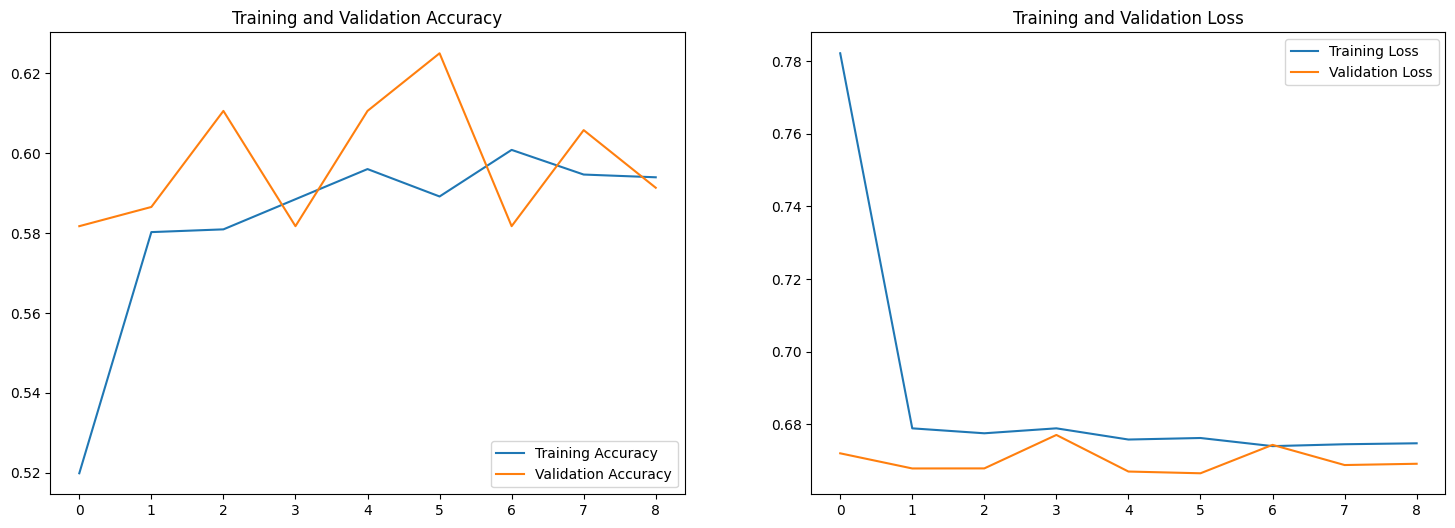

In [61]:
verbose = 1
es_callback = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model = create_RNN(hidden_units=2, hidden_dense_units=64, dense_units=1, input_shape=(lag, 2), 
                activation=['relu', 'sigmoid'])
history = model.fit(train_x, train_y,validation_data=(valid_x,valid_y), epochs=epoch,callbacks=[es_callback], batch_size=batch_size, verbose=verbose)
train_accu = model.evaluate(train_x, train_y, verbose=verbose)[1]
valid_accu = model.evaluate(valid_x, valid_y, verbose=verbose)[1]
test_accu = model.evaluate(test_x, test_y, verbose=verbose)[1]



acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

if es_callback.stopped_epoch == 0:
    epochs_range = range(epoch)
else:
    epochs_range = range(es_callback.stopped_epoch+1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



# 3

In [65]:
train_x_cnn = np.array(train_x)
# print(train_x_cnn.shape)
train_x_cnn = train_x_cnn.reshape((train_x_cnn.shape[0], train_x_cnn.shape[1], train_x_cnn.shape[2], 1))
# print(train_x_cnn.shape)

(1458, 32, 2)
(1458, 32, 2, 1)


In [75]:
train_x_cnn = np.array(train_x)
train_y_cnn = np.array(train_y)
train_x_cnn = train_x_cnn.reshape((train_x_cnn.shape[0], train_x_cnn.shape[1], train_x_cnn.shape[2], 1))

valid_x_cnn = np.array(valid_x)
valid_y_cnn = np.array(valid_y)

valid_x_cnn = valid_x_cnn.reshape((valid_x_cnn.shape[0], valid_x_cnn.shape[1], valid_x_cnn.shape[2], 1))

test_x_cnn = np.array(test_x)
test_y_cnn = np.array(test_y)
test_x_cnn = test_x_cnn.reshape((test_x_cnn.shape[0], test_x_cnn.shape[1], test_x_cnn.shape[2], 1))


In [79]:
es_callback = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)


cnn_model = keras.Sequential()

cnn_model.add(Input((lag, 2, 1), name="Input"))
conv2D = Conv2D(16, kernel_size=(2,2), activation='relu', padding='same')
cnn_model.add(conv2D)

cnn_model.add(AveragePooling2D(pool_size=(1, 2)))
# cnn_model.add(MaxPooling2D(pool_size=(1, 2)))
  
cnn_model.add(Flatten(name="Flat"))
cnn_model.add(Dense(64, activation="relu", name="Dense"))
cnn_model.add(Dense(1, activation="sigmoid", name="Output"))
cnn_model.summary()


# model.summary()

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 2, 16)         80        
                                                                 
 average_pooling2d_2 (Averag  (None, 32, 1, 16)        0         
 ePooling2D)                                                     
                                                                 
 Flat (Flatten)              (None, 512)               0         
                                                                 
 Dense (Dense)               (None, 64)                32832     
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 32,977
Trainable params: 32,977
Non-trainable params: 0
_________________________________________________

In [80]:
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = cnn_model.fit(train_x_cnn, train_y_cnn, validation_data=(valid_x_cnn,valid_y_cnn), epochs=10, callbacks=[es_callback],verbose=verbose)

Epoch 1/10
46/46 [==============================] - 5s 13ms/step - loss: 0.6837 - accuracy: 0.5754 - val_loss: 0.6937 - val_accuracy: 0.5817
Epoch 2/10
46/46 [==============================] - 0s 5ms/step - loss: 0.6813 - accuracy: 0.5933 - val_loss: 0.6684 - val_accuracy: 0.6346
Epoch 3/10
46/46 [==============================] - 0s 5ms/step - loss: 0.6832 - accuracy: 0.5816 - val_loss: 0.6792 - val_accuracy: 0.5817
Epoch 4/10
46/46 [==============================] - 0s 5ms/step - loss: 0.6783 - accuracy: 0.5871 - val_loss: 0.6708 - val_accuracy: 0.5625
Epoch 5/10
46/46 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.5981 - val_loss: 0.6750 - val_accuracy: 0.5817
Epoch 6/10
46/46 [==============================] - 0s 5ms/step - loss: 0.6763 - accuracy: 0.5967 - val_loss: 0.6691 - val_accuracy: 0.5817
Epoch 7/10
46/46 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.5850 - val_loss: 0.6689 - val_accuracy: 0.6298
Epoch 8/10
46/46 [=

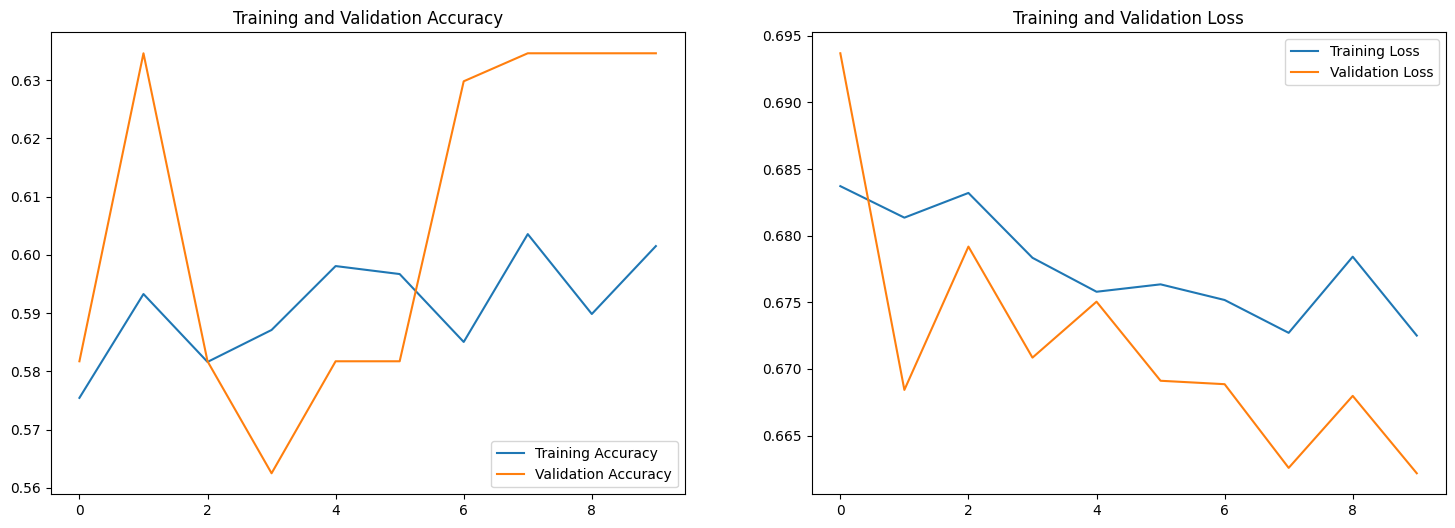

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

if es_callback.stopped_epoch == 0:
    epochs_range = range(epoch)
else:
    epochs_range = range(es_callback.stopped_epoch+1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
